# Implementation de l'active learning

In [1]:
import pandas as pd
import numpy as np
from joblib import load
from preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from joblib import load

## Masquage des labels

In [4]:
# Chargement des donnees
data = pd.read_csv('/home/onyxia/PROJET_STATAPP/Data/Cleans/Data_for_active_learning.csv')
data.head(2)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,FraudFound_P,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,0,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,0,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61


In [5]:
#Données non labelisees et des labels
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']
X.head(3)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,300,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61
2,2,Honda,Urban,Male,Married,47,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,1,7 years,No,No,External,none,no change,1 vehicle,2


In [6]:
# Chargement du pipeline
preprocessor = load("preprocessor.joblib")

In [7]:
all_cols = binary_cols + label_cols + freq_cols + ordinal_cols + scale_cols # definit dans preprocessor.py
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_cols)
X_preprocessed.head(2)

,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,AgentType,Make,MaritalStatus,PolicyType,VehiclePrice,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,DriverRating,Deductible,Age,delay_weeks
0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,2.0,0.000065,5.0,4.0,0.0,2.0,0.0,2.0,2.0,1.0,300.0,-1.516574,-1.856357
1,1.0,1.0,1.0,1.0,0.0,0.0,6.0,2.0,0.022570,5.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,400.0,-0.489689,0.602140


In [8]:
len(X_preprocessed)

15419

## Séparation des donnees en 3 parties test/seed/pool

In [9]:
# 20% pour le test
X_pool_full, X_test, y_pool_full, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, stratify=y, random_state=42
)

# 2% d'observations initiales pour le seed dans le x_pool
X_init, X_pool, y_init, y_pool = train_test_split(
    X_pool_full, y_pool_full, train_size=0.02, stratify=y_pool_full, random_state=42
)

In [10]:
print ("Nombre de lignes du pool final : ",len(X_pool) ,
 "; Nombre de lignes du seed : ", len(X_init))


Nombre de lignes du pool final :  12089 ; Nombre de lignes du seed :  246


## Initialisation du modèle et SMOTE

In [11]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)
smote = SMOTE(sampling_strategy=0.25, random_state=42)


## Boucle de l'active learning

In [14]:
# Tracking des résultats
results = []
#________________________________ Boucle d'active learning________________________________#

while len(X_init) < 12089 and len(X_pool) > 0:

    # ---- SMOTE sur le init ----
    X_init_smote, y_init_smote = smote.fit_resample(X_init, y_init)

    # ---- Entraînement ----
    model.fit(X_init_smote, y_init_smote)

    # ---- Évaluation sur le test set ----
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "labels_used": len(X_init),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "f1": f1_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "auc": roc_auc_score(y_test, y_test_proba)
    })

    # ---- Prédiction sur le pool ----
    y_pool_proba = model.predict_proba(X_pool)[:, 1]

    # ---- Echantillonage aleatoire ----

    x_batch, X_pool_new, y_batch, y_pool_new = train_test_split(
    X_pool, y_pool, train_size = 50, stratify = y_pool, random_state=42)

    # ---- Ajout des points au init ----
    X_init = pd.concat([X_init, x_batch])
    y_init = pd.concat([y_init, y_batch])

    # ---- Suppression des points du pool ----
    X_pool = X_pool_new
    y_pool = y_pool_new

    print(
        f"Iteration: {len(results)} | "
        #f"Nouveaux labels: {n_select} | "
        f"Total labels: {len(X_init)} | "
        #f"Youden threshold: {youden_threshold:.3f}"
    )

# -----------------------
# Résultats finaux
# -----------------------
results_df = pd.DataFrame(results)
results_df


[LightGBM] [Info] Number of positive: 81, number of negative: 325
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 406, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199507 -> initscore=-1.389376
[LightGBM] [Info] Start training from score -1.389376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,labels_used,accuracy,f1,recall,precision,auc
0,346,0.921530,0.129496,0.097297,0.193548,0.678644
1,396,0.926070,0.095238,0.064865,0.179104,0.673787
2,446,0.925097,0.101167,0.070270,0.180556,0.691897
3,496,0.924125,0.100000,0.070270,0.173333,0.688690
4,546,0.921530,0.116788,0.086486,0.179775,0.701606
...,...,...,...,...,...,...
230,11846,0.939689,0.097087,0.054054,0.476190,0.813380
231,11896,0.938716,0.086957,0.048649,0.409091,0.804937
232,11946,0.939689,0.105769,0.059459,0.478261,0.813235
233,11996,0.939364,0.087805,0.048649,0.450000,0.810602


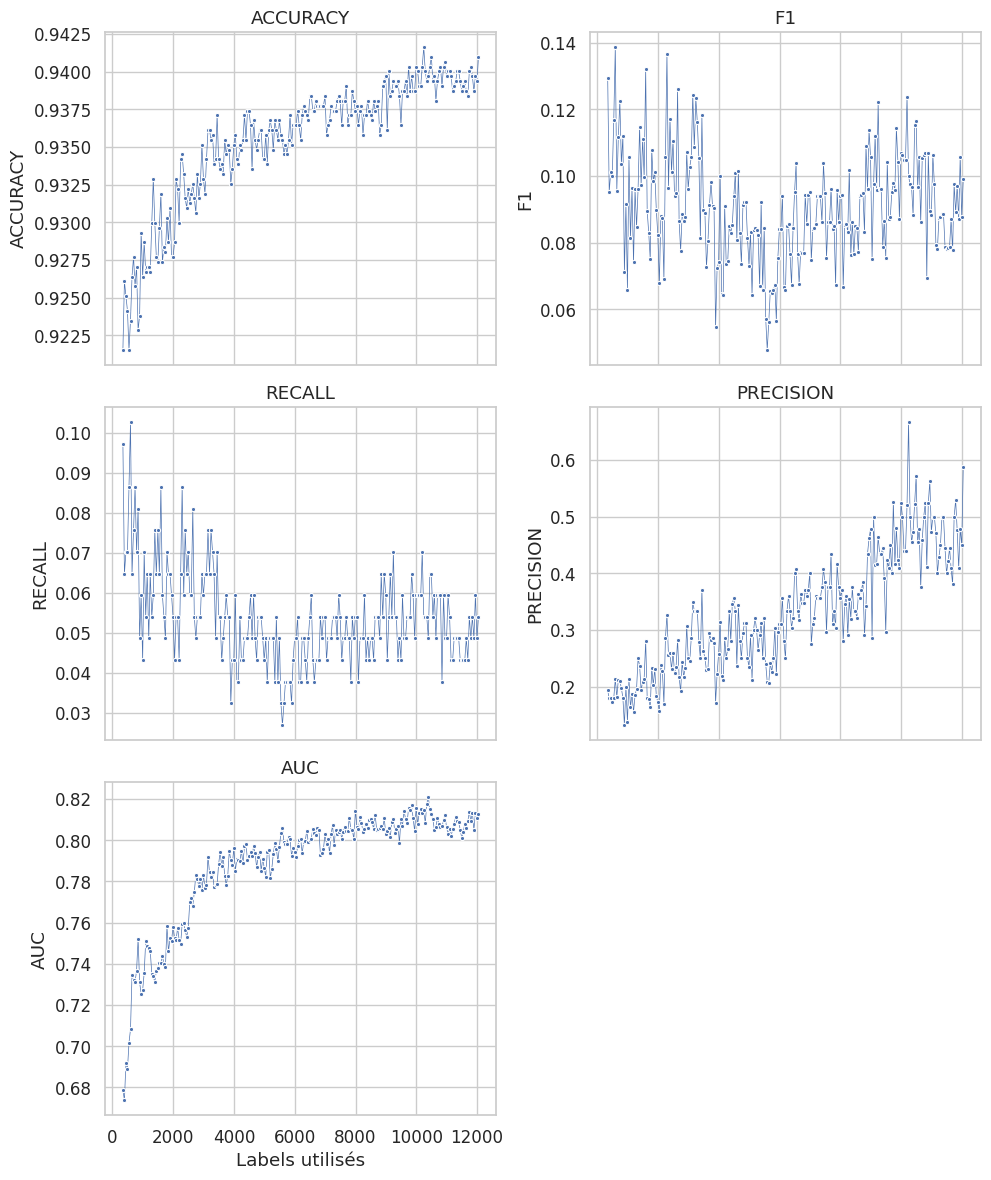

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Style seaborn
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

metrics = ["accuracy", "f1", "recall", "precision", "auc"]
n_metrics = len(metrics)

# Déterminer nombre de colonnes pour 2 lignes
n_rows = 3
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)

# Aplatir axes si nécessaire
axes = axes.flatten()

for i, m in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(
        x=results_df["labels_used"],
        y=results_df[m],
        marker=".",
        linewidth=0.5,
        ax=ax
    )
    ax.set_title(m.upper())
    ax.set_xlabel("Labels utilisés")
    ax.set_ylabel(m.upper())

# Supprimer les axes vides si n_metrics < n_rows * n_cols
for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
